In [1]:
# Predicting Revenue Grid of Customers based on their characteristics

In [2]:
import warnings

warnings.filterwarnings ('ignore')

import pandas as pd
import numpy as np
import re

from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from mypipes import *

In [3]:
#Loading train and test data
bd_train = pd.read_csv(r'rg_train.csv')
bd_test = pd.read_csv(r'rg_test.csv')

#bd_test doesn't have the response variable
print(bd_train.shape)
print(bd_test.shape)

(8124, 32)
(2031, 31)


In [4]:
#Splitting bd_train into train and test
bd_train_train , bd_train_test = train_test_split(bd_train, test_size = 0.2 , random_state = 42)
bd_train_train.to_csv(r'rg_train_train.csv', index =False)
bd_train_test.to_csv(r'rg_train_test.csv', index =False)

In [5]:
bd_train_train = pd.read_csv(r'rg_train_train.csv')
bd_train_test = pd.read_csv(r'rg_train_test.csv')

print(bd_train_train.shape)
print(bd_train_test.shape)

(6499, 32)
(1625, 32)


In [6]:
bd_train_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           6499 non-null   int64  
 1   children                         6499 non-null   object 
 2   age_band                         6499 non-null   object 
 3   status                           6499 non-null   object 
 4   occupation                       6499 non-null   object 
 5   occupation_partner               6499 non-null   object 
 6   home_status                      6499 non-null   object 
 7   family_income                    6499 non-null   object 
 8   self_employed                    6499 non-null   object 
 9   self_employed_partner            6499 non-null   object 
 10  year_last_moved                  6499 non-null   int64  
 11  TVarea                           6499 non-null   object 
 12  post_code           

In [7]:
# Obtaining the numerical variables
num_vars = list(bd_train_train.select_dtypes(exclude = ['object']).columns)
num_vars

['REF_NO',
 'year_last_moved',
 'Average.Credit.Card.Transaction',
 'Balance.Transfer',
 'Term.Deposit',
 'Life.Insurance',
 'Medical.Insurance',
 'Average.A.C.Balance',
 'Personal.Loan',
 'Investment.in.Mutual.Fund',
 'Investment.Tax.Saving.Bond',
 'Home.Loan',
 'Online.Purchase.Amount',
 'Revenue.Grid',
 'Investment.in.Commudity',
 'Investment.in.Equity',
 'Investment.in.Derivative',
 'Portfolio.Balance']

In [8]:
# Excluding REF_ID and the target variable
num_vars = [i for i in num_vars if i not in ['REF_NO','Revenue.Grid']]
num_vars

['year_last_moved',
 'Average.Credit.Card.Transaction',
 'Balance.Transfer',
 'Term.Deposit',
 'Life.Insurance',
 'Medical.Insurance',
 'Average.A.C.Balance',
 'Personal.Loan',
 'Investment.in.Mutual.Fund',
 'Investment.Tax.Saving.Bond',
 'Home.Loan',
 'Online.Purchase.Amount',
 'Investment.in.Commudity',
 'Investment.in.Equity',
 'Investment.in.Derivative',
 'Portfolio.Balance']

In [9]:
# Obtaining the categorical variables
cat_vars = list(bd_train_train.select_dtypes(include = ['object']).columns)
cat_vars

['children',
 'age_band',
 'status',
 'occupation',
 'occupation_partner',
 'home_status',
 'family_income',
 'self_employed',
 'self_employed_partner',
 'TVarea',
 'post_code',
 'post_area',
 'gender',
 'region']

In [10]:
# Refining the categorical variable list by removing features that require custom transformation
cat_vars = [i for i in cat_vars if i not in ['children','age_band','post_code','post_area','family_income']]
cat_vars

['status',
 'occupation',
 'occupation_partner',
 'home_status',
 'self_employed',
 'self_employed_partner',
 'TVarea',
 'gender',
 'region']

In [11]:
# DATA PREPROCESSING PIPELINE
p1 = pdPipeline([
    ('var_select',VarSelector(num_vars)),
    ('missing_trt',DataFrameImputer())
])

p2 = pdPipeline([
    ('var_select',VarSelector(cat_vars)),
    ('missing_trt',DataFrameImputer()),
    ('create_dummies',get_dummies_Pipe())
    ])

p3=pdPipeline([
    ('var_select', VarSelector(['age_band'])),
    ('custom_fico', custom_age_band()),
    ('missing_trt', DataFrameImputer())
])

p4=pdPipeline([
    ('var_select', VarSelector(['family_income'])),
    ('custom_fico', custom_family_income()),
    ('missing_trt', DataFrameImputer())
])

p5=pdPipeline([
    ('var_select', VarSelector(['children'])),
    ('string_clean1', string_clean(replace_it='Zero', replace_with='0')),
    ('string_clean2', string_clean(replace_it='4+', replace_with='4')),
    ('convert_to_numeric',convert_to_numeric()),
    ('missing_trt', DataFrameImputer())
])
  

In [12]:
data_pipe=FeatureUnion([
    ('p1',p1),
    ('p2',p2),
    ('p3',p3),
    ('p4',p4),
    ('p5',p5)
])

data_pipe

FeatureUnion(transformer_list=[('p1',
                                pdPipeline(steps=[('var_select',
                                                   VarSelector(feature_names=['year_last_moved',
                                                                              'Average.Credit.Card.Transaction',
                                                                              'Balance.Transfer',
                                                                              'Term.Deposit',
                                                                              'Life.Insurance',
                                                                              'Medical.Insurance',
                                                                              'Average.A.C.Balance',
                                                                              'Personal.Loan',
                                                                              'Investment.in.Mutual.Fund',
                                                                              'Investment.Tax.Saving.Bond',
                                                                              'Home.Loan',
                                                                              'Online.Purchase.Amount'...
                                                   custom_family_income()),
                                                  ('missing_trt',
                                                   DataFrameImputer())])),
                               ('p5',
                                pdPipeline(steps=[('var_select',
                                                   VarSelector(feature_names=['children'])),
                                                  ('string_clean1',
                                                   string_clean(replace_it='Zero',
                                                                replace_with='0')),
                                                  ('string_clean2',
                                                   string_clean(replace_it='4+',
                                                                replace_with='4')),
                                                  ('convert_to_numeric',
                                                   convert_to_numeric()),
                                                  ('missing_trt',
                                                   DataFrameImputer())]))])

In [13]:
# Training the preprocessing engine on the training data
dp_fit = data_pipe.fit(bd_train_train)

In [14]:
# Extracting the final list of column names generated by the pipeline
dp_fit.get_feature_names_out()

array(['p1__year_last_moved', 'p1__Average.Credit.Card.Transaction',
       'p1__Balance.Transfer', 'p1__Term.Deposit', 'p1__Life.Insurance',
       'p1__Medical.Insurance', 'p1__Average.A.C.Balance',
       'p1__Personal.Loan', 'p1__Investment.in.Mutual.Fund',
       'p1__Investment.Tax.Saving.Bond', 'p1__Home.Loan',
       'p1__Online.Purchase.Amount', 'p1__Investment.in.Commudity',
       'p1__Investment.in.Equity', 'p1__Investment.in.Derivative',
       'p1__Portfolio.Balance', 'p2__status_Partner',
       'p2__status_Single/Never Married', 'p2__status_Divorced/Separated',
       'p2__status_Widowed', 'p2__occupation_Professional',
       'p2__occupation_Retired', 'p2__occupation_Secretarial/Admin',
       'p2__occupation_Housewife', 'p2__occupation_Business Manager',
       'p2__occupation_Unknown', 'p2__occupation_Manual Worker',
       'p2__occupation_Other', 'p2__occupation_partner_Unknown',
       'p2__occupation_partner_Professional',
       'p2__occupation_partner_Retired',


In [15]:
columns = [re.sub('p\d__', '', nm) for nm in dp_fit.get_feature_names_out()]
columns

['year_last_moved',
 'Average.Credit.Card.Transaction',
 'Balance.Transfer',
 'Term.Deposit',
 'Life.Insurance',
 'Medical.Insurance',
 'Average.A.C.Balance',
 'Personal.Loan',
 'Investment.in.Mutual.Fund',
 'Investment.Tax.Saving.Bond',
 'Home.Loan',
 'Online.Purchase.Amount',
 'Investment.in.Commudity',
 'Investment.in.Equity',
 'Investment.in.Derivative',
 'Portfolio.Balance',
 'status_Partner',
 'status_Single/Never Married',
 'status_Divorced/Separated',
 'status_Widowed',
 'occupation_Professional',
 'occupation_Retired',
 'occupation_Secretarial/Admin',
 'occupation_Housewife',
 'occupation_Business Manager',
 'occupation_Unknown',
 'occupation_Manual Worker',
 'occupation_Other',
 'occupation_partner_Unknown',
 'occupation_partner_Professional',
 'occupation_partner_Retired',
 'occupation_partner_Manual Worker',
 'occupation_partner_Business Manager',
 'occupation_partner_Secretarial/Admin',
 'occupation_partner_Housewife',
 'occupation_partner_Other',
 'home_status_Own Home',


In [16]:
len(columns)

72

In [17]:
x_train_train = pd.DataFrame(data = dp_fit.transform(bd_train_train), columns = columns)
x_train_test = pd.DataFrame(data = dp_fit.transform(bd_train_test), columns = columns)

In [18]:
x_train_train.head()
bd_train_train['Revenue.Grid'].value_counts(dropna=False)

Revenue.Grid
2    5814
1     685
Name: count, dtype: int64

In [19]:
# Converting the response variable to an indicator variable
y_train_train = (bd_train_train['Revenue.Grid']==1).astype(int)
y_train_test = (bd_train_test['Revenue.Grid']==1).astype(int)
y_train_train.value_counts()

Revenue.Grid
0    5814
1     685
Name: count, dtype: int64

In [20]:
x_train_train.shape

(6499, 72)

In [21]:
x_train_test.shape

(1625, 72)

In [22]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [23]:
# Defining the base model for selection due to many predictor variables
base_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

In [24]:
# Running RFECV: This finds the optimal number of features AND performs stepwise elimination
# step=1 so it removes one variable at a time
# cv=5 ensures the selection is robust across different data folds
selector = RFECV(estimator=base_model, step=1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
selector = selector.fit(x_train_train, y_train_train)

print(f"Optimal number of features found: {selector.n_features_}")

Optimal number of features found: 63


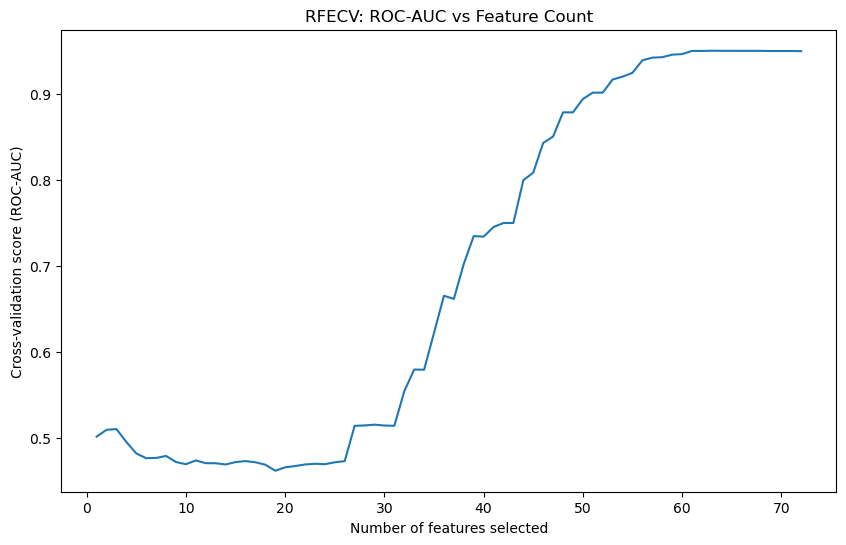

In [25]:
#Visualization for optimal number of variables tp prevent overfitting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (ROC-AUC)")
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), 
         selector.cv_results_['mean_test_score'])
plt.title("RFECV: ROC-AUC vs Feature Count")
plt.show()

In [26]:
# Filtering the data to keep only the 'Stepwise-Selected' features
selected_columns = x_train_train.columns[selector.support_]
x_train_train_selected = x_train_train[selected_columns]
x_train_test_selected = x_train_test[selected_columns]

In [27]:
# Running GridSearchCV on the optimized feature set
from sklearn.model_selection import GridSearchCV
params={'class_weight': ['balanced', None],
        'penalty': ['l1', 'l2'],
        'C':[.0001,.0005,.001,.005,.01,.05,.1,1,2,5]}
#L1 LASSO Makes coeffs 0

#L2 Ridge Suppresses coeffs but doesnt make them 0

grid_search = GridSearchCV(base_model, param_grid=params, cv=5, scoring="roc_auc", n_jobs=-1, verbose=20)
grid_search.fit(x_train_train_selected, y_train_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1,
                               2, 5],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=20)

In [28]:
grid_search.best_estimator_

LogisticRegression(C=0.05, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [29]:
logr=grid_search.best_estimator_

In [30]:
# Printing the report for the the top 3 models 
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.6f} (std: {1:.6f})".format(
                results['mean_test_score'] [candidate],
                results['std_test_score'] [candidate]))
            print("Parameters: {0}".format(results['params'] [candidate]))
            print("")

In [31]:
report(grid_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.954654 (std: 0.014674)
Parameters: {'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l1'}

Model with rank: 2
Mean validation score: 0.954200 (std: 0.014867)
Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.953694 (std: 0.016220)
Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}



In [32]:
logr = LogisticRegression(**{'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l1'}, solver = 'liblinear')

In [33]:
# Fitting the model on the train data using the parameters of the best model
logr.fit(x_train_train_selected,y_train_train)

LogisticRegression(C=0.05, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [34]:
logr.intercept_

array([-1.54560733])

In [35]:
# Getting the coeffcients of all predictor variables 
list(zip(x_train_train_selected.columns, logr.coef_[0]))

[('Average.Credit.Card.Transaction', np.float64(0.029247963015127307)),
 ('Term.Deposit', np.float64(-0.013430836305526486)),
 ('Life.Insurance', np.float64(0.021204351966098812)),
 ('Personal.Loan', np.float64(-0.027220970090928366)),
 ('Investment.in.Mutual.Fund', np.float64(0.004961046619921698)),
 ('Investment.Tax.Saving.Bond', np.float64(0.09799297275609989)),
 ('Home.Loan', np.float64(-0.07063424972124842)),
 ('Online.Purchase.Amount', np.float64(0.05464111288474478)),
 ('Investment.in.Commudity', np.float64(-0.03458825332592303)),
 ('Investment.in.Equity', np.float64(-0.019103022695054997)),
 ('status_Partner', np.float64(0.0)),
 ('status_Single/Never Married', np.float64(0.0)),
 ('status_Divorced/Separated', np.float64(0.0)),
 ('status_Widowed', np.float64(0.0)),
 ('occupation_Professional', np.float64(0.0)),
 ('occupation_Secretarial/Admin', np.float64(0.0)),
 ('occupation_Housewife', np.float64(0.0)),
 ('occupation_Business Manager', np.float64(0.0)),
 ('occupation_Unknown', 

In [36]:
# Even though 63 variables came out as optimal , lasso forces the coefficients of 48 variables to be 0 
# Hence we only have 15 variables in our model with non zero coefficients

In [37]:
# Creating a DataFrame of the variables and their coefficients
coef_df = pd.DataFrame({
    'Feature': x_train_train_selected.columns,
    'Coefficient': logr.coef_[0]
})

# Filtering out the variables with non zero coefficients
final_vars = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

print(final_vars)

                            Feature  Coefficient
5        Investment.Tax.Saving.Bond     0.097993
7            Online.Purchase.Amount     0.054641
0   Average.Credit.Card.Transaction     0.029248
2                    Life.Insurance     0.021204
4         Investment.in.Mutual.Fund     0.004961
1                      Term.Deposit    -0.013431
9              Investment.in.Equity    -0.019103
3                     Personal.Loan    -0.027221
8           Investment.in.Commudity    -0.034588
23       occupation_partner_Retired    -0.036671
6                         Home.Loan    -0.070634
37                  TVarea_Meridian    -0.087701
33                 self_employed_No    -0.215634
48                    gender_Female    -0.253674
34         self_employed_partner_No    -0.596111


In [38]:
# Predicting the probability of the classes
logr.predict_proba(x_train_train_selected)

array([[0.93458829, 0.06541171],
       [0.9724386 , 0.0275614 ],
       [0.97347948, 0.02652052],
       ...,
       [0.98915604, 0.01084396],
       [0.93624172, 0.06375828],
       [0.63773227, 0.36226773]])

In [39]:
train_train_score = logr.predict_proba(x_train_train_selected)[:,1]
real = y_train_train

In [40]:
cutoffs = np.linspace(0.01,0.99,99)

In [41]:
train_train_score

array([0.06541171, 0.0275614 , 0.02652052, ..., 0.01084396, 0.06375828,
       0.36226773])

In [42]:
F1_all = []
Precision_all = []
Recall_all = []
Acc_all = []
KS_all = []

for cutoff in cutoffs :

    predicted = (train_train_score>cutoff).astype(int)

    TP = ((predicted==1) & (real==1)).sum()
    TN = ((predicted==0) & (real==0)).sum()
    FP = ((predicted==1) & (real==0)).sum()
    FN = ((predicted==0) & (real==1)).sum()

    P = TP+FN
    N = TN+FP

    Precision = TP/(TP+FP)
    Recall = TP/P
    F1 = (2*Precision*Recall)/(Precision+Recall)
    Acc = (TP+TN)/(P+N)
    KS = (TP/P)-(FP/N)

    Precision_all.append(Precision)
    Recall_all.append(Recall)
    F1_all.append(F1)
    Acc_all.append(Acc)
    KS_all.append(KS)

In [43]:
pd.DataFrame({'Cut-off' : cutoffs , 'F1' : F1_all, 'Precision' : Precision_all , 'Recall': Recall_all , 'Acc': Acc_all , 'KS' : KS_all})

,Cut-off,F1,Precision,Recall,Acc,KS
0,0.01,0.209156,0.116832,0.997080,0.205262,0.109051
1,0.02,0.220746,0.124157,0.994161,0.260194,0.167879
2,0.03,0.232240,0.131503,0.992701,0.308201,0.220255
3,0.04,0.244597,0.139511,0.991241,0.354670,0.270911
4,0.05,0.259139,0.149119,0.988321,0.404370,0.323890
...,...,...,...,...,...,...
94,0.95,0.621500,0.815166,0.502190,0.935529,0.488774
95,0.96,0.594243,0.816327,0.467153,0.932759,0.454769
96,0.97,0.577438,0.836565,0.440876,0.931990,0.430728
97,0.98,0.547431,0.847095,0.404380,0.929528,0.395780


In [44]:
mycutoffs = cutoffs[F1_all==max(F1_all)]
mycutoffs

array([0.7])

In [45]:
logr.intercept_

array([-1.54560733])

In [46]:
# Predicting the probability of classes for the test data
logr.predict_proba(x_train_test_selected)

array([[0.99837541, 0.00162459],
       [0.98212231, 0.01787769],
       [0.81066401, 0.18933599],
       ...,
       [0.93286055, 0.06713945],
       [0.93385625, 0.06614375],
       [0.4140008 , 0.5859992 ]])

In [47]:
train_test_score=logr.predict_proba(x_train_test_selected)[:,1]
train_test_score

array([0.00162459, 0.01787769, 0.18933599, ..., 0.06713945, 0.06614375,
       0.5859992 ])

In [48]:
# Getting the classes of the test data by comparing the probabilities with the cutoff with the max F1 score 
(train_test_score>mycutoffs).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve 
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):

    #plots the roc curve based of the probabilities

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    score = roc_auc_score(true_y, y_prob)
    print(f"ROC AUC: {score:.4f}")

ROC AUC: 0.9563


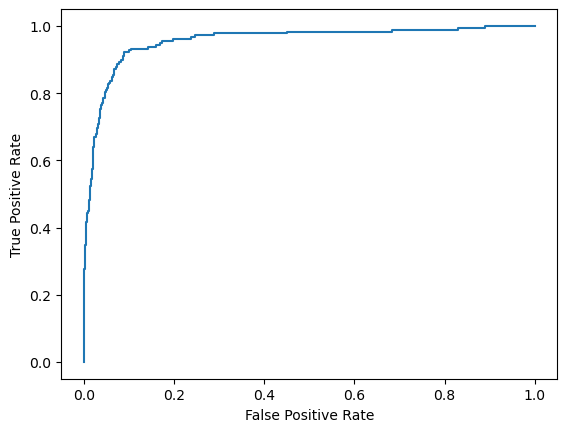

In [50]:
plot_roc_curve(y_train_test, train_test_score)

In [51]:
#Predicting Revenue Grid for original test data
bd_test.shape

(2031, 31)

In [52]:
x_test = pd.DataFrame(data = dp_fit.transform(bd_test), columns = columns)
x_test_selected = x_test[selected_columns]

In [53]:
x_test_selected.shape

(2031, 63)

In [54]:
logr.predict_proba(x_test_selected)

array([[0.9977958 , 0.0022042 ],
       [0.96313181, 0.03686819],
       [0.99436915, 0.00563085],
       ...,
       [0.97799301, 0.02200699],
       [0.73251569, 0.26748431],
       [0.81965509, 0.18034491]])

In [55]:
test_score=logr.predict_proba(x_test_selected)[:,1]
test_score

array([0.0022042 , 0.03686819, 0.00563085, ..., 0.02200699, 0.26748431,
       0.18034491])

In [56]:
# Getting the classes for the original test data 
results = (test_score>mycutoffs).astype(int)
results

array([0, 0, 0, ..., 0, 0, 0])

In [57]:
final_submission = pd.DataFrame({
    'REF_NO': bd_test['REF_NO'], 
    'Revenue_Grid': pd.Series(results).map({0: 2, 1: 1})
})

In [58]:
final_submission['Revenue_Grid'].value_counts()

Revenue_Grid
2    1766
1     265
Name: count, dtype: int64

In [59]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [60]:
clf = RandomForestClassifier()

In [61]:
# Setting the list of parameters 
param_dist = {"n_estimators" : [100,200,300,400,500,700,1000], "max_features" : [5,10,20,25,30,35], "bootstrap" : [True , False],
              "class_weight" :[None , 'balanced'], "max_depth" : [None, 5,10,15,20,30,50,70], "min_samples_leaf" : [1,2,5,10,15,20],
              "min_samples_split" : [2,5,10,15,20]}
n_iter_search = 5

In [62]:
random_search = RandomizedSearchCV(clf, param_distributions = param_dist,random_state = 2,
                                   n_iter = n_iter_search, scoring = 'f1', cv = 5, 
                                   n_jobs = -1, verbose =20)
random_search.fit(x_train_train,y_train_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced'],
                                        'max_depth': [None, 5, 10, 15, 20, 30,
                                                      50, 70],
                                        'max_features': [5, 10, 20, 25, 30, 35],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 700, 1000]},
                   random_state=2, scoring='f1', verbose=20)

In [63]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       max_features=5, min_samples_leaf=2,
                       min_samples_split=20)

In [64]:
# Printing the report of the top 3 models
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.776527 (std: 0.021651)
Parameters: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 5, 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.763122 (std: 0.025042)
Parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 30, 'max_depth': 10, 'class_weight': None, 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.760681 (std: 0.012352)
Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 25, 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': False}



In [65]:
rf = RandomForestClassifier(**{'n_estimators': 100, 'random_state' : 2, 'min_samples_split': 20, 
                               'min_samples_leaf': 2,'max_features': 5, 'max_depth': 20, 
                               'class_weight': 'balanced', 'bootstrap': False})
rf.fit(x_train_train,y_train_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       max_features=5, min_samples_leaf=2, min_samples_split=20,
                       random_state=2)

In [66]:
# Fitting the model with the best parameters on the test data
y_pred_rf = rf.predict(x_train_test)
y_pred_rf[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [67]:
print(classification_report(y_train_test, y_pred_rf, target_names = ['2','1']))

              precision    recall  f1-score   support

           2       0.98      0.97      0.98      1447
           1       0.79      0.83      0.81       178

    accuracy                           0.96      1625
   macro avg       0.89      0.90      0.89      1625
weighted avg       0.96      0.96      0.96      1625



In [68]:
#Confusion matrix for Random Forest
pd.crosstab(y_train_test,y_pred_rf,rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,1409,38
1,31,147


ROC AUC: 0.9811


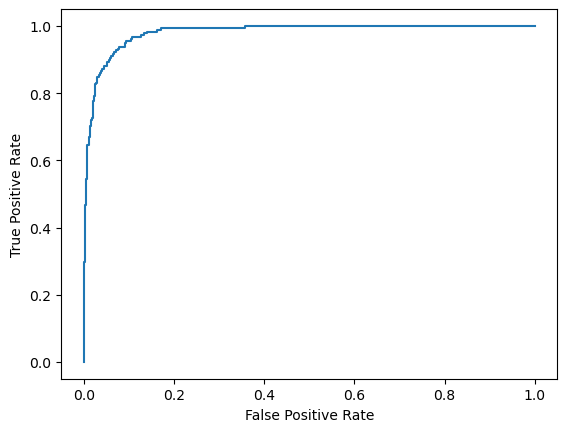

In [69]:
plot_roc_curve(y_train_test, rf.predict_proba(x_train_test)[:,1])

In [70]:
#Prediction on the original test data 
y_test_pred_rf = rf.predict(x_test)
final_submission2 = pd.DataFrame({
    'REF_NO': bd_test['REF_NO'], 
    'Revenue_Grid': pd.Series(y_test_pred_rf).map({0: 2, 1: 1})
})
final_submission2.head()

,REF_NO,Revenue_Grid
0,9,2
1,13,2
2,18,2
3,21,2
4,26,2


In [71]:
final_submission2['Revenue_Grid'].value_counts()

Revenue_Grid
2    1791
1     240
Name: count, dtype: int64

In [72]:
#Feature Importance to determine the most important predictor variables affecting the target variable
feat_imp_df = pd.DataFrame({'feature' : x_train_train.columns ,'importance' : rf.feature_importances_})
feat_imp_df = feat_imp_df.sort_values('importance',ascending = False)
feat_imp_df['cum_imp'] = np.cumsum(feat_imp_df['importance'])
feat_imp_df.reset_index()

,index,feature,importance,cum_imp
0,11,Online.Purchase.Amount,0.200268,0.200268
1,9,Investment.Tax.Saving.Bond,0.097198,0.297466
2,13,Investment.in.Equity,0.093537,0.391003
3,15,Portfolio.Balance,0.073550,0.464553
4,12,Investment.in.Commudity,0.072710,0.537262
...,...,...,...,...
67,54,TVarea_Ulster,0.000481,0.998750
68,67,region_Northern Ireland,0.000424,0.999174
69,53,TVarea_Unknown,0.000401,0.999575
70,39,home_status_Live in Parental Hom,0.000325,0.999900


In [73]:
# XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [74]:
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [75]:
# Setting the list of parameters 
param_dist_xgb = {"n_estimators": [100, 200, 300, 500], "max_depth": [3, 5, 10, 15], "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.5, 0.8, 1.0], "colsample_bytree": [0.5, 0.7, 1.0], "scale_pos_weight": [1, 2, 5, 8.5, 10] }
n_iter_search = 5

In [76]:
random_search_xgb = RandomizedSearchCV(clf_xgb, param_distributions=param_dist_xgb, random_state = 2,
                                        n_iter=5, scoring='f1', cv=5, 
                                        n_jobs=-1, verbose=20)
random_search_xgb.fit(x_train_train, y_train_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 500],
                                        'scale_pos_weight': [1, 2, 5, 8.5, 10],
                                        'subsample': [0.5, 0.8, 1.0]},
                   random_state=2, scoring='f1', verbose=20)

In [77]:
random_search_xgb.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [78]:
# Printing the report of the top 3 models
report(random_search_xgb.cv_results_,3)

Model with rank: 1
Mean validation score: 0.844820 (std: 0.017178)
Parameters: {'subsample': 0.8, 'scale_pos_weight': 8.5, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Model with rank: 2
Mean validation score: 0.843130 (std: 0.012110)
Parameters: {'subsample': 0.5, 'scale_pos_weight': 8.5, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Model with rank: 3
Mean validation score: 0.836300 (std: 0.014681)
Parameters: {'subsample': 0.5, 'scale_pos_weight': 5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}



In [79]:
xg_b = XGBClassifier(**{'subsample': 0.8, 'scale_pos_weight': 8.5, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1,
                        'colsample_bytree': 1.0, 'random_state': 2 })
xg_b.fit(x_train_train,y_train_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [80]:
# Fitting the model with the best parameters on the test data
y_pred_xg_b = xg_b.predict(x_train_test)
y_pred_xg_b[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [81]:
print(classification_report(y_train_test, y_pred_xg_b, target_names = ['2','1']))

              precision    recall  f1-score   support

           2       0.98      0.99      0.98      1447
           1       0.89      0.83      0.86       178

    accuracy                           0.97      1625
   macro avg       0.93      0.91      0.92      1625
weighted avg       0.97      0.97      0.97      1625



In [82]:
#Confusion matrix for XGBoost
pd.crosstab(y_train_test, y_pred_xg_b, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,1429,18
1,31,147


ROC AUC: 0.9916


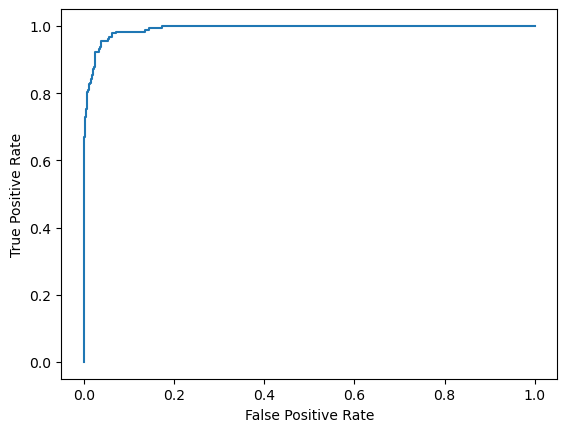

In [83]:
plot_roc_curve(y_train_test, xg_b.predict_proba(x_train_test)[:,1])

In [84]:
#Prediction on the original test data 
y_test_pred_xg_b = xg_b.predict(x_test)
final_submission3 = pd.DataFrame({ 'REF_NO': bd_test['REF_NO'], 'Revenue_Grid': pd.Series(y_test_pred_xg_b).map({0: 2, 1: 1})
})
final_submission3.head()

,REF_NO,Revenue_Grid
0,9,2
1,13,2
2,18,2
3,21,2
4,26,2


In [85]:
final_submission3['Revenue_Grid'].value_counts()

Revenue_Grid
2    1815
1     216
Name: count, dtype: int64

In [86]:
# Feature Importance for XGBoost
xg_b_imp_df = pd.DataFrame({'feature': x_train_train.columns, 'importance': xg_b.feature_importances_
})

xg_b_imp_df = xg_b_imp_df.sort_values('importance', ascending=False)
xg_b_imp_df['cum_imp'] = np.cumsum(xg_b_imp_df['importance'])
xg_b_imp_df.reset_index()

,index,feature,importance,cum_imp
0,11,Online.Purchase.Amount,0.105986,0.105986
1,12,Investment.in.Commudity,0.088150,0.194136
2,9,Investment.Tax.Saving.Bond,0.064817,0.258953
3,4,Life.Insurance,0.032353,0.291306
4,64,region_North,0.031475,0.322781
...,...,...,...,...
67,37,home_status_Rent from Council/HA,0.000882,1.000000
68,39,home_status_Live in Parental Hom,0.000000,1.000000
69,35,occupation_partner_Other,0.000000,1.000000
70,67,region_Northern Ireland,0.000000,1.000000


In [88]:
#from sklearn.metrics import roc_auc_score, f1_score

# Define models along with their specific datasets
model_configs = {
    "Logistic Regression": {
        "model": logr,
        "data": x_train_test_selected
    },
    "Random Forest": {
        "model": rf,
        "data": x_train_test
    },
    "XGBoost": {
        "model": xg_b,
        "data": x_train_test
    }
}

for name, config in model_configs.items():
    model = config["model"]
    current_x = config["data"]
    
    # Get probabilities for the positive class (1)
    probs = model.predict_proba(current_x)[:, 1]
    preds = model.predict(current_x)
    
    print(f"--- {name} ---")
    print(f"ROC-AUC: {roc_auc_score(y_train_test, probs):.4f}")
    print(f"F1-Score (Class 1): {f1_score(y_train_test, preds):.4f}")
    print("-" * 25)

--- Logistic Regression ---
ROC-AUC: 0.9563
F1-Score (Class 1): 0.6934
-------------------------
--- Random Forest ---
ROC-AUC: 0.9811
F1-Score (Class 1): 0.8099
-------------------------
--- XGBoost ---
ROC-AUC: 0.9916
F1-Score (Class 1): 0.8571
-------------------------


In [89]:
#Final prediction based on XGBoost since it's the best model in this case
final_submission3.to_csv(r'Revenue_Grid_Pred.csv', index =False)